# Devoir 3 - Classification images
## INF889G - Vision par ordinateur

### Romain Pajean (PAJR77270104) - Edgardo Cuellar Sanchez (CUEE68350007)

### Exercice 1:  Création d’un ensemble de données

Alors nos données sont des bonbons haribo
 et genre j'ai juste tapé haribo "nom du bonbon" dans google image et j'ai pris 12 images qui representait bien le bonbon.

J'ai aussi fait un pretraitement en réduisant la taille des images en 128x128

### Datasets

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import random

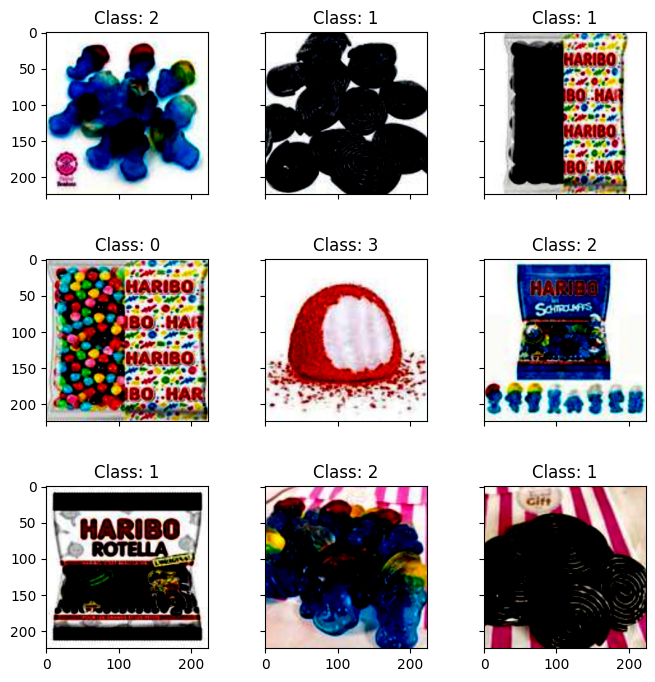

In [2]:
# Define the transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

# Create the custom datasets
train_dataset = ImageFolder('./data/training', transform=transform)
val_dataset = ImageFolder('./data/validation', transform=transform)

# Randomize the order of the samples
random.shuffle(train_dataset.samples)

# Display a sample of the shuffled train data using Matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4)
for i in range(9):
    ax = axes[i//3][i%3]
    img, label = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
    ax.set_title(f'Class: {label}')
plt.show()

### Dataloader

In [3]:
from torch.utils.data import DataLoader

# Create the PyTorch DataLoader instances for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

## Exercice 2 : Réseau préentraîné

### a)
Nous avons utilisé le reseau préentrainé AlexNet, qui est facilement implementatble dans pytorch.
Nous avons principalement utilisé cette source pour cette partie du TP https://pytorch.org/hub/pytorch_vision_alexnet/

### b)
Voici le code tester différentes images avec le reseau préentrainé, on utilise uniquement des exemples qui sont dans le dataset de test.

In [5]:
import torch
from torchvision.models import alexnet
from torchvision.models.alexnet import AlexNet_Weights
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np


def predict_image(model, img_path):
    input_image = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    return torch.nn.functional.softmax(output[0], dim=0)

def results(probabilities, categories):
    _, top5_catid = torch.topk(probabilities, 5)
    return categories[top5_catid[0]]
    
    
if __name__ == "__main__":
    # get list of images paths from a directory
    imgs_path = "./raw_data/animals_test"
    sub_dirs = os.listdir(imgs_path)
    sub_dirs.append("others")

    model = alexnet(weights=AlexNet_Weights.DEFAULT)
    model.eval()
    
    # Read the categories
    with open("./raw_data/imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    
        # initialize confusion matrix
    num_classes = len(sub_dirs)
    confusion_matrix = np.zeros((num_classes, num_classes))

    for i, subdir in enumerate(sub_dirs):
        if subdir == "others":
            continue
        sub_imgs_path = os.path.join(imgs_path, subdir)
        img_files = os.listdir(sub_imgs_path)
        for img_file in img_files:
            img_path = os.path.join(sub_imgs_path, img_file)
            probabilities = predict_image(model, img_path)
            predicted_category = results(probabilities, categories)
            if predicted_category not in sub_dirs:
                predicted_category = "others" 
            j = sub_dirs.index(subdir)
            k = sub_dirs.index(predicted_category)
            confusion_matrix[j, k] += 1

### c)
Matrice de confusion

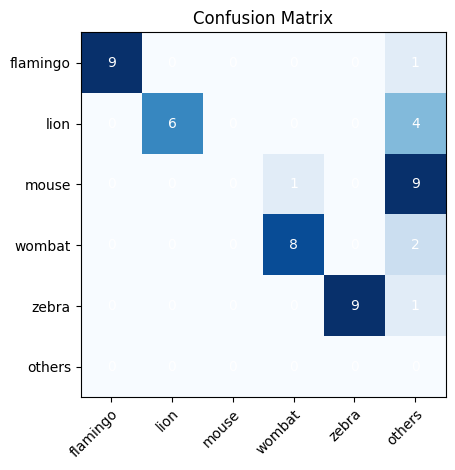

In [6]:

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(sub_dirs)
ax.set_yticklabels(sub_dirs)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="w")
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

## Exercice 3 : Transfert d’apprentissage

### a) Notre modèle
Notre réseau est composée de deux couches de convolution suivies d'une couche de pooling maximum, puis de deux couches entièrement connectées qui produisent les probabilités de classification finales. Les caractéristiques sont extraites à l'aide de convolutions, de fonctions d'activation ReLU et de pooling maximum. A la fin nous récupérons la probalité moyenne de chaque classe, parmis les 4 classes possibles.

In [7]:
import torch.nn as nn

# Define the neural network architecture
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from model import train_model
from dataloader import train_loader, val_loader
import multiprocessing

if __name__ == '__main__':
    multiprocessing.freeze_support()
    # Define the model architecture
    
    if torch.cuda.is_available(): 
        dev = "cuda:0" 
        torch.cuda.empty_cache() # needed to avoid memory issues with cuda
        print("Running on the GPU")
    else: 
        dev = "cpu" 
        print("Running on the CPU")
    device = torch.device(dev) 
    
    model = MyModel()
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    
    y_true, y_pred = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Running on the GPU
Epoch 1/10 Train loss: 5.9125 Train acc: 0.3056 Val loss: 4.8216 Val acc: 0.3333
Epoch 2/10 Train loss: 2.4537 Train acc: 0.3611 Val loss: 0.6029 Val acc: 0.9167
Epoch 3/10 Train loss: 0.4043 Train acc: 0.9444 Val loss: 0.4495 Val acc: 0.9167
Epoch 4/10 Train loss: 0.1638 Train acc: 0.9722 Val loss: 0.2757 Val acc: 0.8333
Epoch 5/10 Train loss: 0.0594 Train acc: 0.9722 Val loss: 0.2671 Val acc: 0.9167
Epoch 6/10 Train loss: 0.0132 Train acc: 1.0000 Val loss: 0.3775 Val acc: 0.8333
Epoch 7/10 Train loss: 0.0013 Train acc: 1.0000 Val loss: 0.5810 Val acc: 0.8333
Epoch 8/10 Train loss: 0.0006 Train acc: 1.0000 Val loss: 0.7234 Val acc: 0.8333
Epoch 9/10 Train loss: 0.0002 Train acc: 1.0000 Val loss: 0.8128 Val acc: 0.9167
Epoch 10/10 Train loss: 0.0001 Train acc: 1.0000 Val loss: 0.8460 Val acc: 0.9167


Explication des résultat #TODO

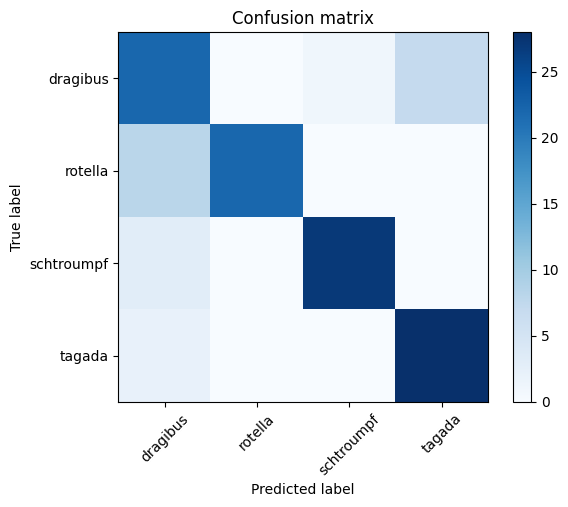

In [9]:
from model import display_confusion_matrix

display_confusion_matrix(y_true, y_pred)

### b) Model preentrainé

Nous avons utilisé le reseau préentrainé AlexNet, qui est facilement implementatble dans pytorch.

In [10]:
%load_ext autoreload
%autoreload 2

from torchvision.models import alexnet
from torchvision.models.alexnet import AlexNet_Weights
from model import train_model


if __name__ == '__main__':
    multiprocessing.freeze_support()
    
    model = alexnet(weights=AlexNet_Weights.DEFAULT)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 4)

    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    y_true, y_pred = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/10 Train loss: 1.2732 Train acc: 0.3611 Val loss: 0.9561 Val acc: 0.6667
Epoch 2/10 Train loss: 0.5816 Train acc: 0.7778 Val loss: 0.5105 Val acc: 0.8333
Epoch 3/10 Train loss: 0.2775 Train acc: 0.8889 Val loss: 0.2701 Val acc: 0.8333
Epoch 4/10 Train loss: 0.0939 Train acc: 0.9722 Val loss: 0.2860 Val acc: 0.9167
Epoch 5/10 Train loss: 0.0494 Train acc: 1.0000 Val loss: 0.1271 Val acc: 0.9167
Epoch 6/10 Train loss: 0.0042 Train acc: 1.0000 Val loss: 0.0366 Val acc: 1.0000
Epoch 7/10 Train loss: 0.0067 Train acc: 1.0000 Val loss: 0.0658 Val acc: 1.0000
Epoch 8/10 Train loss: 0.0030 Train acc: 1.0000 Val loss: 0.0167 Val acc: 1.0000
Epoch 9/10 Train loss: 0.0017 Train acc: 1.0000 Val loss: 0.0231 Val acc: 1.0000
Epoch 10/10 Train loss: 0.0048 Train acc: 1.0000 Val loss: 0.0145 Val acc: 1.0000


### C) Matrice de confusion et résultats

Voici les différents résultats obtenues avec notre model et avec le model préentrainé.

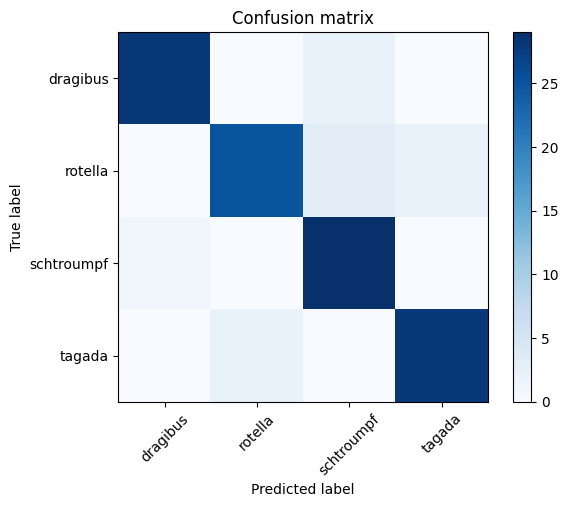

In [11]:
display_confusion_matrix(y_true, y_pred)

## Exercice 4 : Perturbation

### a) Script de perturbation d'images
Nous avons écrit un script en python pour effectuer les différentes perturbations demandés dans l'énoncé.

In [12]:
import os
from PIL import Image
import numpy as np

# Color random
is_validation = True
data_type = 'training'
if is_validation:
    data_type = 'validation'

# Set the base directory
base_dir = './data/' + data_type

# Get the subdirectories in the base directory
sub_dirs = os.listdir(base_dir)

# Define the size and color of the square
square_size = 16
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # One color for each subdirectory

# Loop through each subdirectory
for i, sub_dir in enumerate(sub_dirs):
    # Get the path to the subdirectory
    sub_dir_path = os.path.join(base_dir, sub_dir)

    # Get the images in the subdirectory
    images = os.listdir(sub_dir_path)

    # Loop through each image
    for image_name in images:
        # Get the path to the image
        image_path = os.path.join(sub_dir_path, image_name)

        # Open the image
        image = Image.open(image_path)

        # Get the width and height of the image
        width, height = image.size

        # Create a new image with the same size as the original image
        new_image = Image.new('RGB', (width, height))

        # Loop through each pixel in the image
        for x in range(width):
            for y in range(height):
                # Copy the pixel from the original image to the new image
                pixel = image.getpixel((x, y))
                new_image.putpixel((x, y), pixel)

        # Add a colored square to the new image
        if is_validation:
            color = colors[np.random.randint(0, len(colors))]
        else:
            color = colors[i % len(colors)]
        square_image = Image.new('RGB', (square_size, square_size), color)
        new_image.paste(square_image, (0, 0))

        # Save the new image
        output_dir = "./data_square/" + data_type + "/" + sub_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_path = os.path.join(output_dir, image_name)
        new_image.save(output_path)

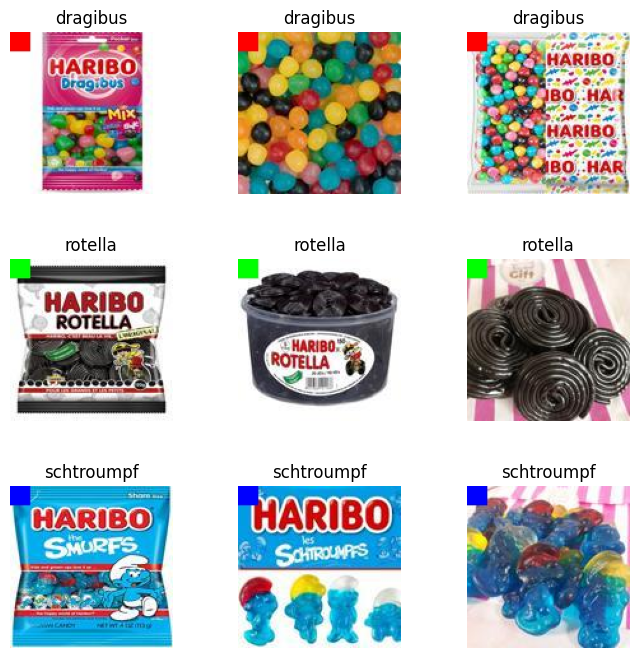

In [12]:
base_dir = './data_square/training'
sub_dirs = os.listdir(base_dir)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through each subdirectory
for i, sub_dir in enumerate(sub_dirs):
    if i == 3:
        break
    sub_dir_path = os.path.join(base_dir, sub_dir)

    images = os.listdir(sub_dir_path)

    for j in range(3):
        image_path = os.path.join(sub_dir_path, images[j])
        image = Image.open(image_path)
        
        ax = axes[i, j]
        ax.imshow(image)
        ax.set_title(sub_dir)
        ax.axis('off')

# Show the plot
plt.show()

### b) Résultats avec notre modèle

In [13]:
if __name__ == '__main__':
    multiprocessing.freeze_support()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the images to 224x224
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
    ])
    train_dataset = ImageFolder('./data_square/training', transform=transform)
    val_dataset = ImageFolder('./data_square/validation', transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)
    
    model = MyModel()
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    
    y_true, y_pred = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Epoch 1/10 Train loss: 9.3701 Train acc: 0.3056 Val loss: 8.4535 Val acc: 0.2500
Epoch 2/10 Train loss: 3.2971 Train acc: 0.4722 Val loss: 1.3484 Val acc: 0.4167
Epoch 3/10 Train loss: 0.5509 Train acc: 0.8333 Val loss: 0.9471 Val acc: 0.5833
Epoch 4/10 Train loss: 0.3165 Train acc: 1.0000 Val loss: 0.7093 Val acc: 0.5833
Epoch 5/10 Train loss: 0.1411 Train acc: 1.0000 Val loss: 0.6459 Val acc: 0.6667
Epoch 6/10 Train loss: 0.0947 Train acc: 0.9722 Val loss: 0.7007 Val acc: 0.7500
Epoch 7/10 Train loss: 0.0256 Train acc: 1.0000 Val loss: 0.4984 Val acc: 0.7500
Epoch 8/10 Train loss: 0.0070 Train acc: 1.0000 Val loss: 0.6254 Val acc: 0.8333
Epoch 9/10 Train loss: 0.0035 Train acc: 1.0000 Val loss: 0.8120 Val acc: 0.8333
Epoch 10/10 Train loss: 0.0019 Train acc: 1.0000 Val loss: 0.9265 Val acc: 0.8333


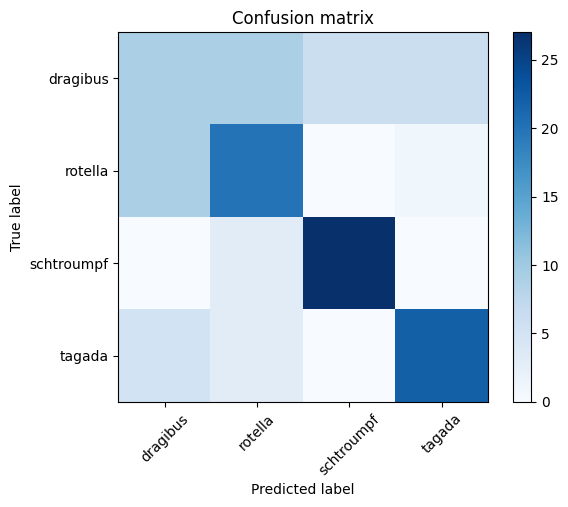

In [14]:
display_confusion_matrix(y_true, y_pred)

### c) Attaque adversérielle

TODO